# Compare Top Feature Performance with z = 200

**Gregory Way, 2019**

Here, I compare the results of aggregating the top 200 features for each algorithm (and the top 200 features for all algorithms combined) with the models originally trained using z = 200.

In [1]:
suppressPackageStartupMessages(library(readr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggrepel))

source(file.path("scripts", "viz_util.R"))

In [2]:
genes <- c("TP53", "PTEN", "PIK3CA", "KRAS", "TTN")

In [3]:
# Load all mutation classification results
mut_path <- file.path("results", "top_feature_classification")
top_feature_df <- load_results(results_path = mut_path,
                               process_output = FALSE, 
                               uses_top_features = TRUE)
top_feature_df <- top_feature_df[['metrics']]
top_feature_df <- top_feature_df %>% dplyr::filter(data_type == 'cv')
top_feature_df$gene_or_cancertype <- factor(top_feature_df$gene_or_cancertype, levels = genes)

head(top_feature_df, 2)

auroc,aupr,gene_or_cancertype,signal,z_dim,seed,algorithm,data_type
0.76680,0.53695,KRAS,real,top_features,any,PCA,cv
0.80918,0.63755,KRAS,real,top_features,any,ICA,cv


In [4]:
# Load all mutation classification results
mut_path <- file.path("results", "mutation")

full_mutation_df <- load_results(results_path = mut_path, process_output = FALSE)

full_mutation_raw_df <- full_mutation_df[['raw_metrics']]
full_mutation_df <- full_mutation_df[['metrics']]

In [5]:
# Process mutation results
full_mutation_df <- full_mutation_df %>% dplyr::filter(z_dim == 200, gene_or_cancertype %in% genes,
                                                       data_type == 'cv')
full_mutation_raw_df <- full_mutation_raw_df %>% dplyr::filter(gene_or_cancertype %in% genes,
                                                       data_type == 'cv')

full_mutation_df$gene_or_cancertype <- factor(full_mutation_df$gene_or_cancertype, levels = genes)
full_mutation_raw_df$gene_or_cancertype <- factor(full_mutation_raw_df$gene_or_cancertype, levels = genes)

full_mutation_df <- full_mutation_df %>%
    dplyr::group_by(algorithm, data_type, gene_or_cancertype, algorithm, signal, z_dim) %>% 
    summarise(mean_auroc = mean(auroc),
              mean_aupr = mean(aupr))

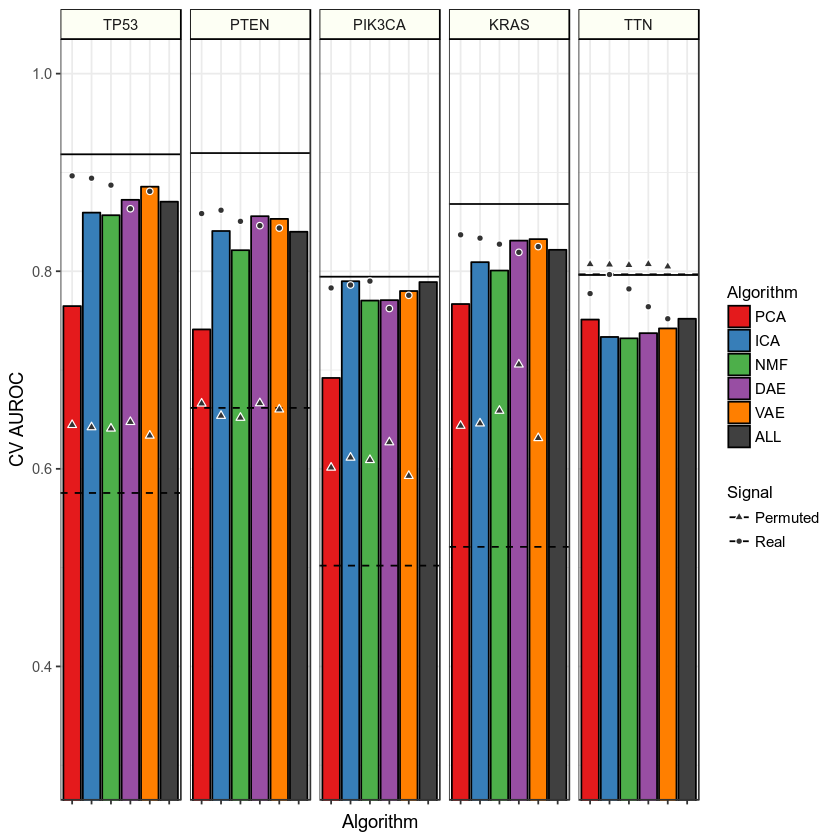

In [6]:
panel_a_auroc <- plot_top_features(top_feature_df,
                                   full_mutation_df,
                                   full_mutation_raw_df,
                                   auroc_or_aupr = 'AUROC')
panel_a_auroc

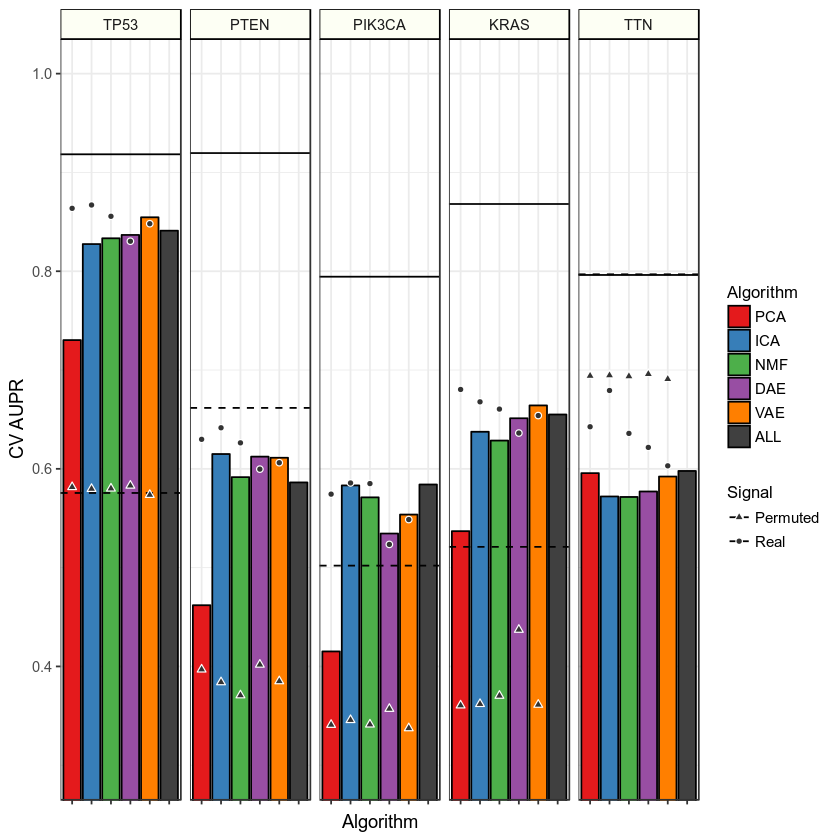

In [7]:
panel_b_aupr <- plot_top_features(top_feature_df,
                                  full_mutation_df,
                                  full_mutation_raw_df,
                                  auroc_or_aupr = 'AUPR')

panel_b_aupr

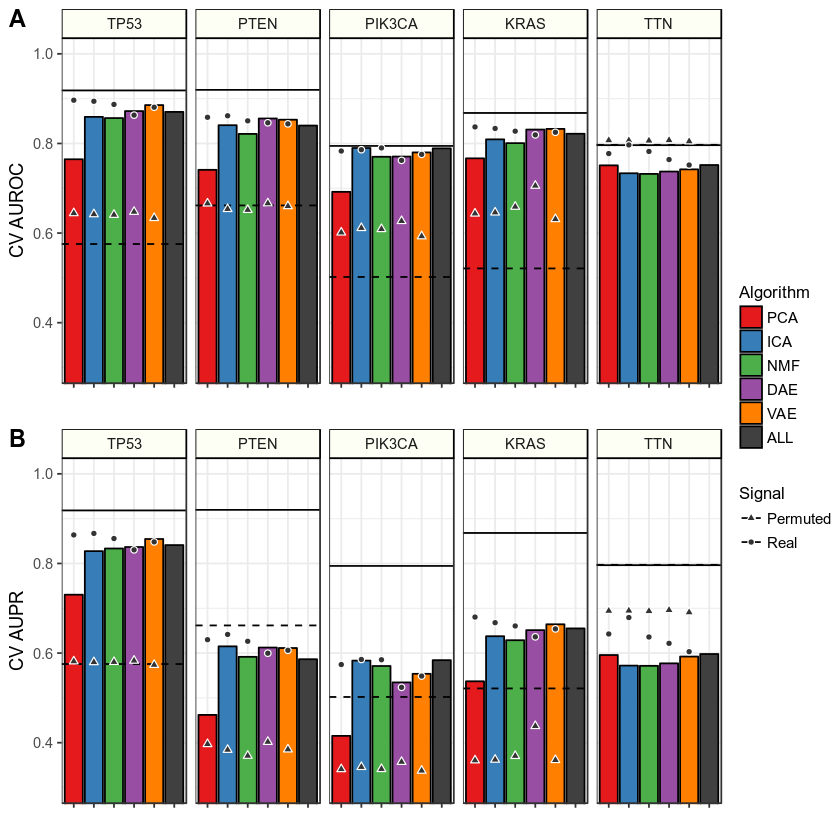

In [8]:
# Create multipanel plot
alg_legend <- cowplot::get_legend(panel_b_aupr)

main_plot <- (
    cowplot::plot_grid(
        panel_a_auroc + theme(legend.position = 'none') + xlab(""),
        panel_b_aupr + theme(legend.position = "none") + xlab(""),
        labels = c("A", "B"),
        ncol = 1,
        nrow = 2
    )
)

main_plot = cowplot::plot_grid(main_plot, alg_legend, rel_widths = c(1, 0.15), ncol = 2)
main_plot

In [9]:
for(extension in c('.png', '.pdf')) {
    sup_file <- paste0("supplemental_tcga_top_feature_summary", extension)
    sup_file <- file.path("figures", sup_file)
    cowplot::save_plot(filename = sup_file,
                       plot = main_plot,
                       base_height = 6,
                       base_width = 7)
}